In [97]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import CubicSpline
from scipy import stats
import networkx as nx
from itertools import combinations
import scipy
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [98]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping


KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [ ]:
df.head()

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,...,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes,number_of_movies_starred_in,average_rating_previous_movies,average_box_office_revenue_previous_movies
140029,Down to You,24419914,92,"['French Language', 'English Language']",['United States of America'],"['Romantic comedy', 'Romance Film', 'Drama', '...",down to you_2000,M,1.88,/m/0xnvg,...,down to you_2000_adam carolla,NaN,NaN,False,2000,5.0,15878,1,5.000000,24419914.0
60320,The Bible: In The Beginning,34900023,171,['English Language'],"['United States of America', 'Italy']","['Christian film', 'Drama', 'Epic', 'World cin...",the bible in the beginning_1966,M,1.85,/m/03bkbh,...,the bible in the beginning_1966_richard harris,NaN,NaN,False,1966,6.2,6385,1,6.200000,34900023.0
389034,Hawaii,34562222,161,['English Language'],['United States of America'],"['Period piece', 'Roadshow theatrical release'...",hawaii_1966,M,1.85,/m/03bkbh,...,hawaii_1966_richard harris,NaN,NaN,False,1966,6.5,3708,1,12.700000,69462245.0
130002,Camelot,31102578,178,['English Language'],['United States of America'],"['Costume drama', 'Musical', 'Roadshow theatri...",camelot_1967,M,1.85,/m/03bkbh,...,camelot_1967_richard harris,NaN,NaN,False,1967,6.6,7624,2,9.650000,50282411.5
182566,Caprice,4075000,95,['English Language'],['United States of America'],"['Romantic comedy', 'Crime Fiction', 'Mystery'...",caprice_1967,M,1.85,/m/03bkbh,...,caprice_1967_richard harris,NaN,NaN,False,1967,5.5,1761,3,8.266667,34879941.0


## **Historic movie industry development**

The movie industry has like the economy grown exponentially during the last 100 years. Hence one might expect higher demands and more competition for each Oscar nomination. It is nevertheless interesting and needed to validate this hypothesis with data. We start with constructing the dataframes used for the analysis, then plot the development of movie releases and actor nomnations since the 1920s. 

Constructing df for analysis

In [ ]:
oscar_nominated = df[df['oscar_nominated']==True]

# Counting movie releases per year
movie_df = df.drop_duplicates(subset='movie_identifier', keep='first', inplace=False)[['movie_identifier', 'year']]
movie_releases = movie_df.groupby('year').size().reset_index(name='count')
movie_releases.head()

,year,count
0,1928,1
1,1929,1
2,1930,1
3,1932,3
4,1933,5


In [ ]:
# Counting oscar nominations per year
oscar_nominations = oscar_nominated.groupby('year').size().reset_index(name='count')
years = pd.DataFrame({'year': movie_releases['year'].unique()})
oscar_nominations = years.merge(oscar_nominations, on='year', how='left').fillna(0)
oscar_nominations.head()

,year,count
0,1928,0.0
1,1929,0.0
2,1930,0.0
3,1932,0.0
4,1933,0.0


In [ ]:
# Counting nominated movies per year
nominations_per_movie_per_year = oscar_nominated.groupby(['year', 'movie_identifier']).agg({'title':'count'}).reset_index().rename(columns={'title':'count'})
unique_nominated_movies_per_year = nominations_per_movie_per_year.groupby(['year']).agg({'movie_identifier':'count'}).reset_index().rename(columns={'movie_identifier':'count'})
unique_nominated_movies_per_year.head()

,year,count
0,1934,1
1,1936,1
2,1939,3
3,1940,1
4,1941,1


In [ ]:
# Merging releases and nominated movies per year
movie_releases_with_nominations = movie_releases.merge(unique_nominated_movies_per_year, on='year', how='left').fillna(0).rename(columns={'count_x' : 'releases', 'count_y':'nominated movies'})
movie_releases_with_nominations.head()

,year,releases,nominated movies
0,1928,1,0.0
1,1929,1,0.0
2,1930,1,0.0
3,1932,3,0.0
4,1933,5,0.0


In [ ]:
# Merging nr. of oscar nominations per year
releases_nominations_counts_df = movie_releases_with_nominations.merge(oscar_nominations, on='year', how='left').fillna(0).rename(columns={'count' : 'oscar nominations'})
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations
0,1928,1,0.0,0.0
1,1929,1,0.0,0.0
2,1930,1,0.0,0.0
3,1932,3,0.0,0.0
4,1933,5,0.0,0.0


In [ ]:
# Calculating % of movies that was nominated each year
releases_nominations_counts_df['%nominated'] = releases_nominations_counts_df['nominated movies'] / releases_nominations_counts_df['releases']
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations,%nominated
0,1928,1,0.0,0.0,0.0
1,1929,1,0.0,0.0,0.0
2,1930,1,0.0,0.0,0.0
3,1932,3,0.0,0.0,0.0
4,1933,5,0.0,0.0,0.0


**Plotting**

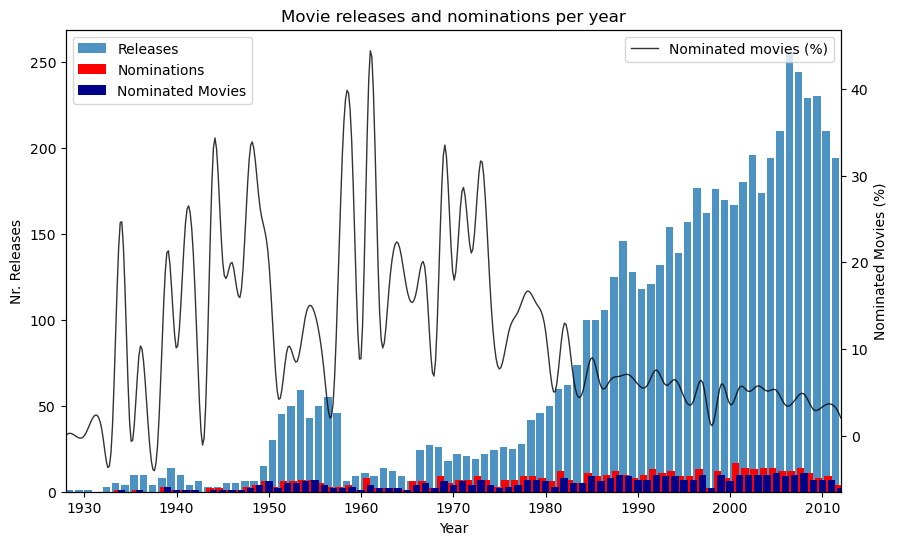

In [ ]:
plt.figure(figsize=(10, 6))

plt.bar(releases_nominations_counts_df['year']+0.4, releases_nominations_counts_df['releases'], label ='Releases', alpha=0.8)
plt.bar(releases_nominations_counts_df['year']-0.4, releases_nominations_counts_df['oscar nominations'], label ='Nominations', color='red')
plt.bar(releases_nominations_counts_df['year'], releases_nominations_counts_df['nominated movies'], label ='Nominated Movies', color='#00008B')


plt.xlabel('Year')
plt.xlim(min(df['year']), max(df['year']))

plt.ylabel('Nr. Releases')

plt.legend()

plt.title('Movie releases and nominations per year')


x = releases_nominations_counts_df['year']
y = releases_nominations_counts_df['%nominated']

cs = CubicSpline(x, y)

x_smooth = np.linspace(min(x), max(x), 500)
y_smooth = cs(x_smooth)
ax2 = plt.twinx()
ax2.set_ylabel('Share')
ax2.plot(x_smooth, 100*y_smooth, color='black', label='Nominated movies (%)', alpha=0.8, linewidth=1)

ax2.set_ylabel('Nominated Movies (%)')
plt.legend()
plt.show()


In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(y=releases_nominations_counts_df['releases'], x=releases_nominations_counts_df['year'], name="Nr. Movie releases"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(y=100*y_smooth, x=x_smooth, name=f"% with a nominated performance"),
    secondary_y=True,
    
)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Nr. of movies", secondary_y=False)
fig.update_yaxes(title_text="%", secondary_y=True)
fig.update_layout(
    title_text="Movie relases and percentage of movies with an Oscar nominated performance since 1928"
)
fig.show()

Clearly, the number of movie releases per year has fluctuated during the last 100 years. However, since the 1960, the number of movie releases has been on a steady uptrend, until the 2010s. In the meantime, the share of movies that has nominated actors has decreased dramatically from 20-40% in thw 30s-70s to far below 10% in the 2010s. 

Review: 

In [246]:
review_df = df.sort_values(by=['movie_identifier', 'oscar_nominated'], ascending=False)
review_df = review_df.drop_duplicates(subset='movie_identifier', keep='first')

In [252]:
nominated_review_df = review_df[review_df['oscar_nominated']==True]
not_nominated_review_df = review_df[review_df['oscar_nominated'] == False]

148537    6.6
406753    6.8
130473    7.4
241509    6.7
51663     8.0
         ... 
191381    7.5
239647    7.7
431312    8.2
36034     7.6
84728     7.5
Name: average_rating, Length: 394, dtype: float64